# 01 - Data Filtering 

In [1]:
import os
import sys
print(sys.version)

3.10.7 (main, Sep  6 2022, 21:22:27) [GCC 12.2.0]


In [2]:
import re

import numpy as np
import scipy.signal
from scipy.signal import find_peaks
from scipy.fft import fft
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [93]:
plt.rcParams["figure.figsize"] = (15, 5)

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

### Load Data 

In [83]:
# fn = './DATA/DEVELOPMENT/EEG/server_data_2/eeg_raw_1024hz.txt'
# fn = './DATA/DEVELOPMENT/EEG/eeg_1024hz_oct18_3.txt'
fn = './DATA/DEVELOPMENT/EEG/eeg_1024hz_no_filter.txt'

In [84]:
data = np.genfromtxt(fn, delimiter='\n')

In [85]:
match = re.findall(r'\d+(?:hz)', fn, flags=re.IGNORECASE)
if len(match) == 1:
    sr = int(match[0][:-2])
else:
    print('unkown sample rate, setting to 256hz')
    sr = 256
    
print(f'sample rate {sr}')

sample rate 1024


In [86]:
SUBSAMPLE = 1

In [87]:
data = data[np.isfinite(data)]
# data = data[np.where(data < 5000)]
data = data[sr:-sr]
data = data[::SUBSAMPLE]
data -= data.mean()
data /= max(data.max(), -data.min())

In [88]:
sr = sr // SUBSAMPLE
print(f'sub-sample rate {sr}')

sub-sample rate 1024


In [89]:
data_t = librosa.samples_to_time(np.arange(len(data)), sr=sr)

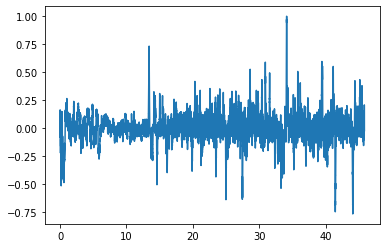

In [90]:
plt.plot(data_t, data);

In [91]:
def plotSpec(signal, sr, f_ratio=1, ax=None, **kwargs):
    mag = np.abs(fft(signal))
    
    if ax is None:
        fig, ax = plt.subplots()
    
    freq = np.linspace(0, sr, len(mag))
    num_bins = int(len(freq) * f_ratio * 0.5)
    
    ax.plot(freq[:num_bins], mag[:num_bins], **kwargs)
    ax.set_xlabel("Frequency (Hz)")
    
    return ax

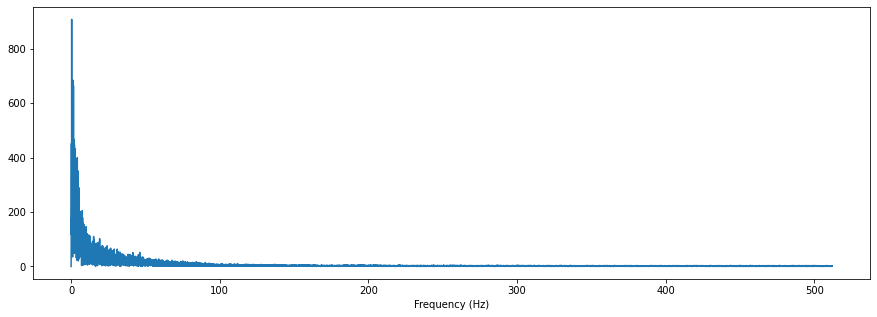

In [94]:
ax = plotSpec(data, sr, 1);
# ax.set_xlim(0.1, 6)
# ax.set_ylim(0, 1e6)

In [95]:
def plotSTFT(data, sr, n_fft = 128):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=[15, 10])
    
    D = librosa.stft(data, n_fft=n_fft, )
    S = np.abs(D)
    rms = librosa.feature.rms(y=data)[0]

    centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=n_fft)
    bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sr, n_fft=n_fft)
    times_spec = librosa.times_like(centroid, sr=sr, n_fft=n_fft)
    times_data =  librosa.samples_to_time(np.arange(len(data)), sr=sr)
    
    axes[0].plot(times_data, data, label='data', alpha=0.6)
    axes[0].plot(times_spec, rms, label='rms', lw=2)
    axes[0].axhline(0, color='black', lw=1)
    axes[0].legend()
    
    librosa.display.specshow(
        librosa.amplitude_to_db(S, ref=np.max), 
        x_axis='time', 
        y_axis='linear', 
        sr=sr, 
        ax=axes[1], 
        hop_length=n_fft//4
    );
    axes[1].fill_between(times_spec, np.maximum(0, centroid[0] - bandwidth[0]),
                    np.minimum(centroid[0] + bandwidth[0], sr/2),
                    alpha=0.5)
    axes[1].plot(times_spec, centroid[0], color='w')
    
    return axes

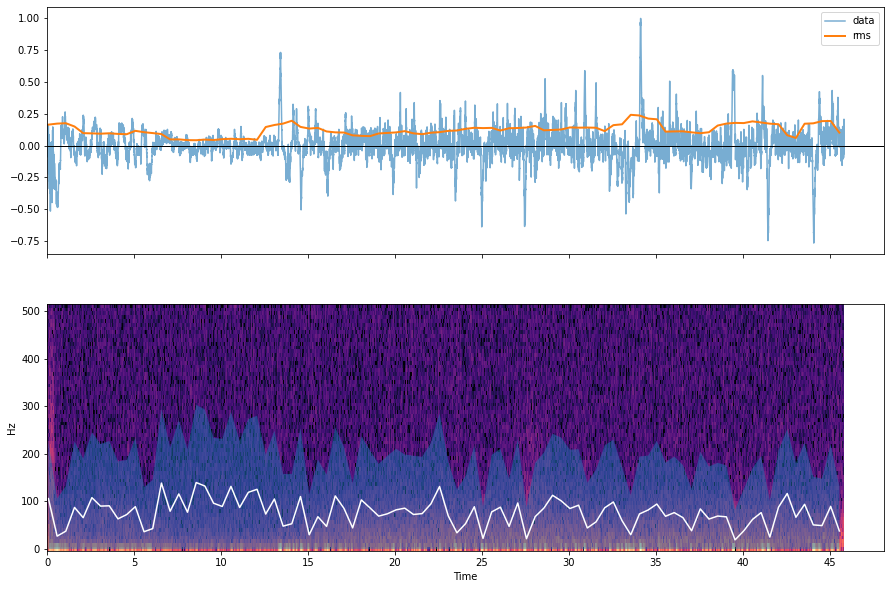

In [96]:
plotSTFT(data, sr)
plt.show()

### Filter signal 

In [97]:
sos_50 = scipy.signal.butter(
    N=4,
    Wn=[48, 52],
    btype='bandstop',
    analog=False,
    output='sos',
    fs=sr
)

In [98]:
# Wn = [0.5, 44.5]; btype = 'bandpass'    # ECG
# Wn = 10; btype = 'lowpass'
Wn = [25, 45]; btype = 'bandpass'    # EEG
# Wn = [0.25, 19.5]; btype = 'bandpass'    # EOG
# Wn = 40; btype = 'lowpass'

sos = scipy.signal.butter(
    N=4,
    Wn=Wn,
    btype=btype,
    analog=False,
    output="sos",
    fs=sr
)

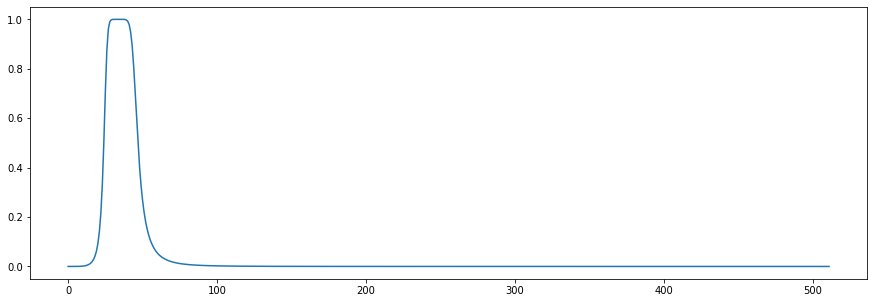

In [99]:
freq, response = scipy.signal.sosfreqz(sos, fs=sr)
plt.plot(freq, np.abs(response));

In [100]:
data_filtered = scipy.signal.sosfilt(sos, data)
rms = librosa.feature.rms(y=data_filtered)[0]

eeg_1024hz_no_filter.txt


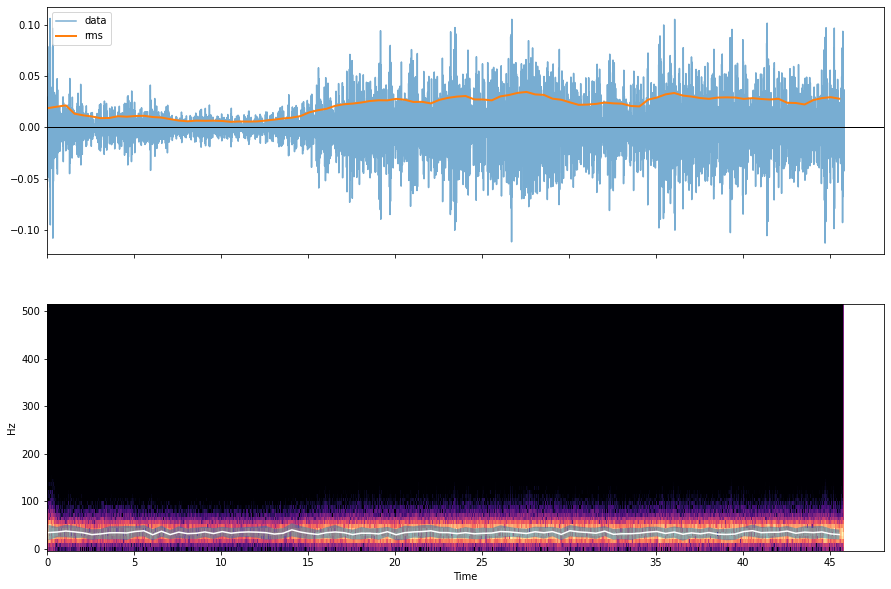

In [101]:
print(fn.split('/')[-1])
plotSTFT(data_filtered, sr)
plt.show()

In [67]:
rms.shape, data_filtered.shape

((23,), (11397,))

### Impulse Detect (EOG) 

In [46]:
mvg_avg = moving_average(data, 150)
avg = np.ones_like(data)*data.mean()

In [47]:
dd = np.diff(data, n=5)

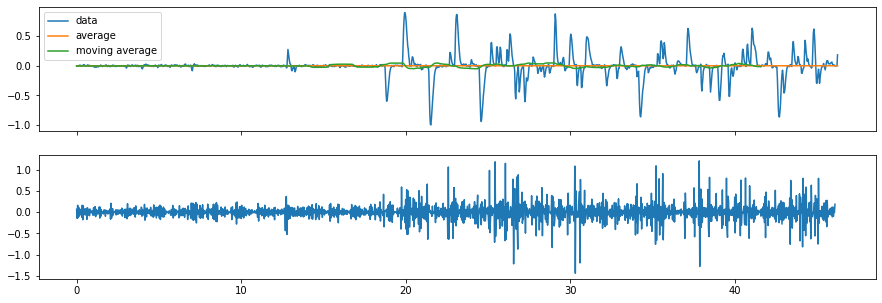

In [48]:
fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(data_t, data, label='data')
axes[0].plot(data_t, avg, label='average')
axes[0].plot(data_t[:len(mvg_avg)], mvg_avg, label='moving average')
axes[0].legend()
axes[1].plot(data_t[:len(dd)], dd);

In [64]:
left = np.where(data - avg > 0.1)
right = np.where(data - avg < -0.1)
dataL = data[left]; dataL_t = data_t[left]
dataR = data[right]; dataR_t = data_t[right]

In [65]:
peak_params = {
    'prominence': 0.1,
    'distance': 4
}

peaksL = find_peaks(dataL, **peak_params)[0]
peaksR = find_peaks(-dataR, **peak_params)[0]

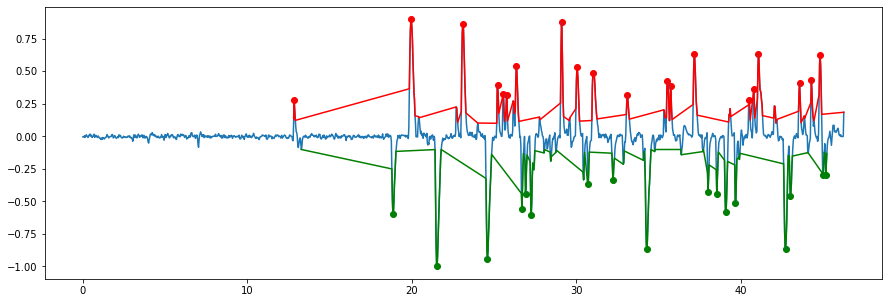

In [66]:
plt.plot(data_t, data)
plt.plot(dataL_t, dataL, color='r')
plt.plot(dataR_t, dataR, color='g')
plt.scatter(dataL_t[peaksL], dataL[peaksL], color='r')
plt.scatter(dataR_t[peaksR], dataR[peaksR], color='g');

### Heart-rate detect (ECG Data)

In [66]:
from ecgdetectors import Detectors
detectors = Detectors(sr)

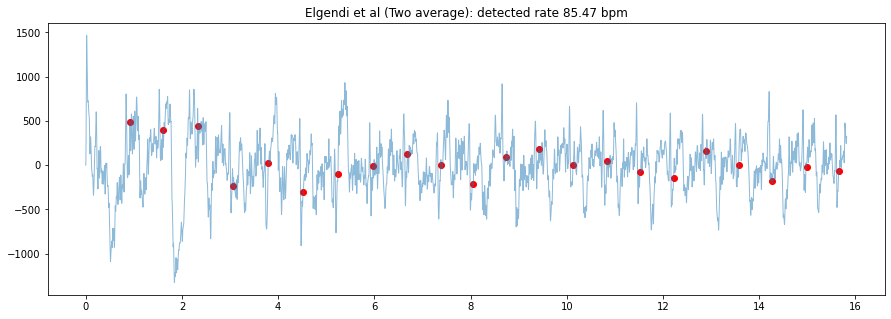

"Matched filter" failed, continuing


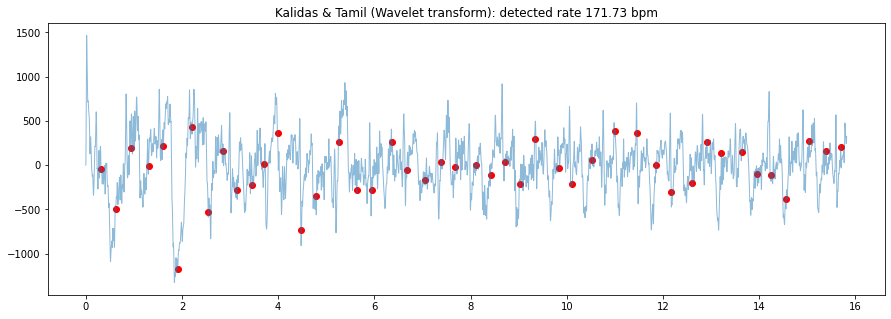

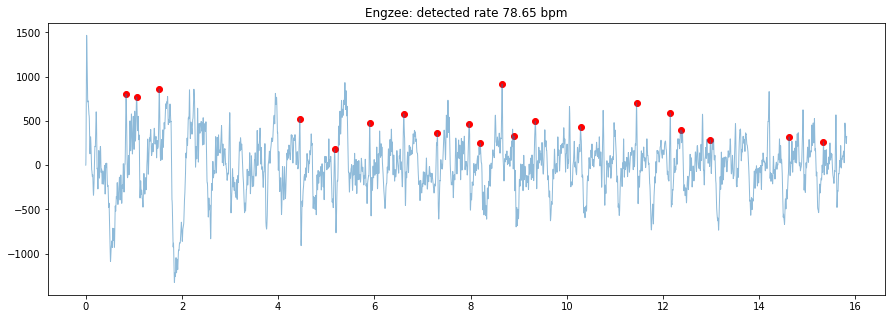

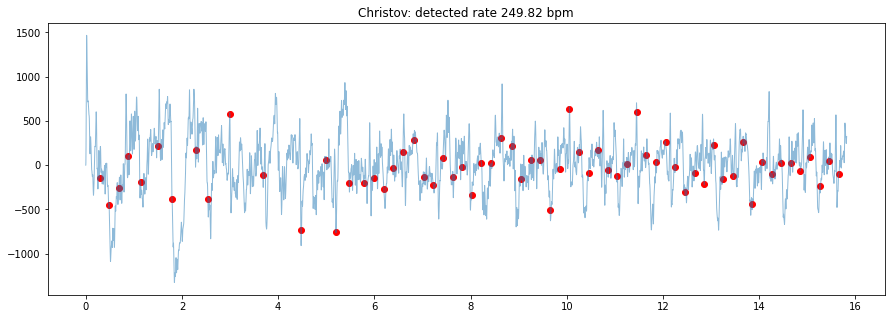

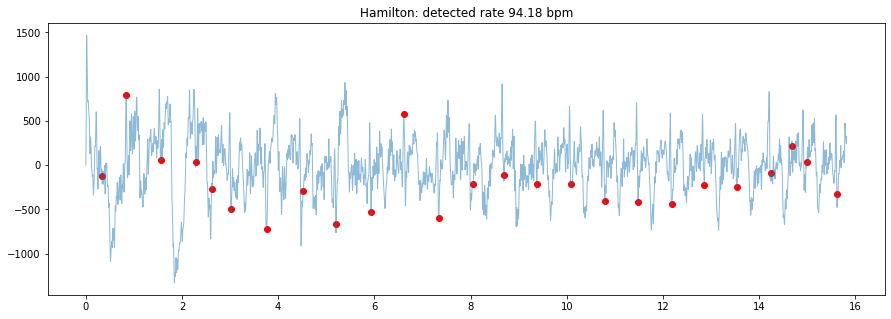

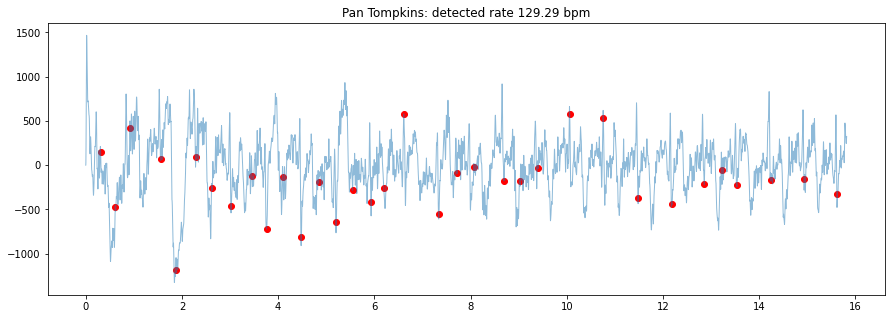

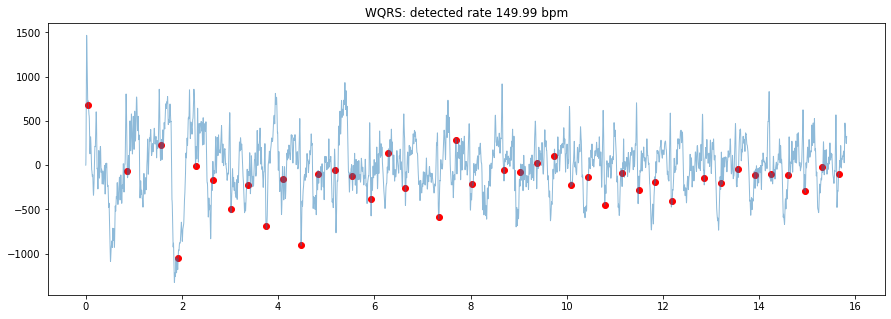

In [67]:
for dname, d_func in detectors.detector_list:
    try:
        r_peaks = d_func(data_filtered)
    except:
        print(f'"{dname}" failed, continuing')
        continue
    
    rate = 60 / np.mean(np.diff(data_t[r_peaks]))
        
    fig, ax = plt.subplots()
    ax.set_title(f'{dname}: detected rate {rate:.2f} bpm')
    ax.plot(data_t, data_filtered, lw=1, alpha=0.5)
    ax.scatter(data_t[r_peaks], data_filtered[r_peaks], color='red')
    plt.show()

In [68]:
import heartpy as hp

In [69]:
# data_scaled = hp.preprocessing.scale_data(data)
data_scaled = hp.preprocessing.filter_signal(data, [0.67, 40], sr, filtertype='bandpass')

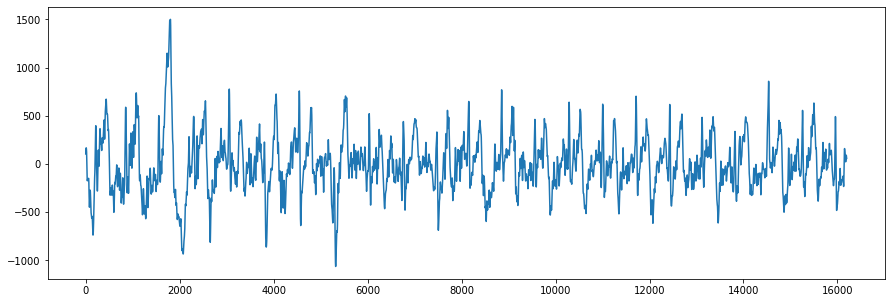

In [70]:
plt.plot(data_scaled);

In [71]:
working_data, measures = hp.process(data_filtered, sr)

In [72]:
# data_enhanced = hp.enhance_peaks(data_filtered, iterations=1)
working_data, measures = hp.process(data_filtered, sr, )

In [73]:
measures

{'bpm': 94.08882082695253,
 'ibi': 637.6953125,
 'sdnn': 85.74493102577308,
 'sdsd': 11.71875,
 'rmssd': 23.619895746968407,
 'pnn20': 0.5,
 'pnn50': 0.0,
 'hr_mad': 20.5078125,
 'sd1': 14.501213286052245,
 'sd2': 8.286407592029832,
 's': 377.50308451873104,
 'sd1/sd2': 1.7500000000000047,
 'breathingrate': 0.2615062761506276}

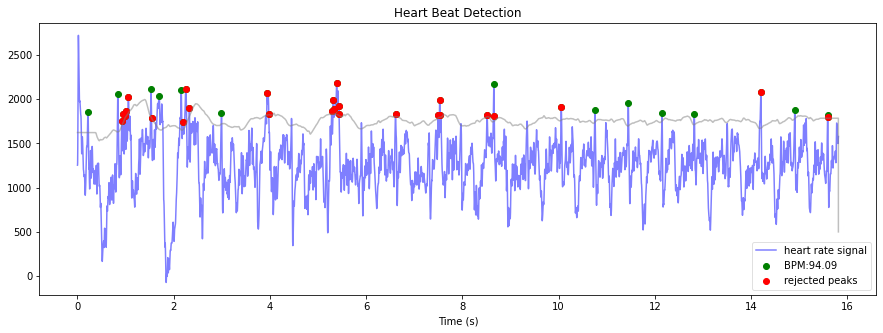

In [74]:
ax = hp.plotter(working_data, measures, title='Heart Beat Detection', moving_average=True, show=False)

In [193]:
ex_data, _ = hp.load_exampledata(0) #this example set is sampled at 100Hz

working_data, measures = hp.process(ex_data, 100.0)

/home/arran/.local/lib/python3.10/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


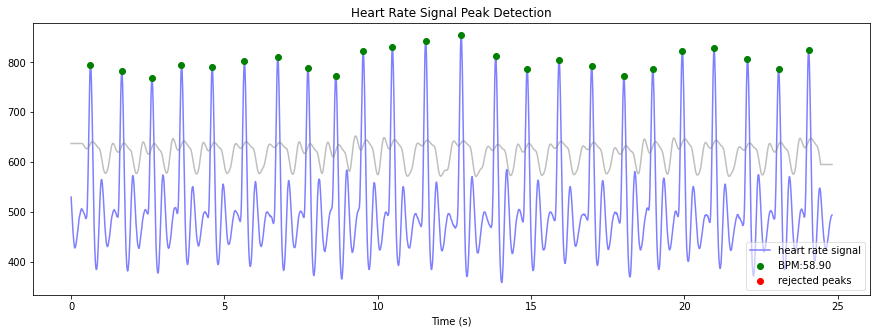

In [194]:
hp.plotter(working_data, measures, show=True, moving_average=True)